In [1]:
from phi.torch.flow import CenteredGrid, extrapolation, Box, math
import numpy as np
import torch
import torch.nn as nn

N = 128
STEPS = 32
DT = 1./ STEPS
NU = 0.2 / np.pi

velocity = CenteredGrid(0, extrapolation.PERIODIC, x = N, bounds = Box[-1:1])

REFERENCE_DATA = math.tensor(
    [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312]
    , math.spatial('x')
)

SOLUTION_T16 = CenteredGrid(REFERENCE_DATA, extrapolation.PERIODIC, x=N, bounds=Box[-1:1])

In [2]:
print(type(velocity.values.native()))

<class 'torch.Tensor'>


In [51]:
velocities = [velocity]

from phi.torch.flow import math, diffuse, advect, field

with math.record_gradients(velocity.values):
    for time_step in range(STEPS):
        v1 = diffuse.explicit(1.0*velocities[-1], NU, DT, substeps=1)
        v2 = advect.semi_lagrangian(v1,v1,DT)
        velocities.append(v2)
    
    loss = field.l2_loss(velocities[16] - SOLUTION_T16) * 2.0 / N
    grad = math.gradients(loss, velocity.values)

print("Loss : {:.3f}".format(loss))


Loss : 0.383


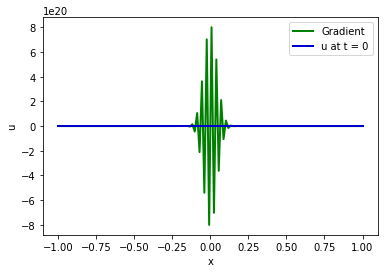

In [52]:
import pylab as plt

fig = plt.figure().gca()
pltx = np.linspace(-1,1,N)

fig.plot(pltx, grad.numpy('x'), lw = 2, color = 'green', label = 'Gradient')
fig.plot(pltx, velocity.values.numpy('x'), lw = 2, color = 'mediumblue', label = 'u at t = 0')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

In [53]:
# pytorch can not get exact solution by diffuse.explicit and advect.semi_lagrangian
# loss can not be converged

LR = 0.001
grads = []

velocity = CenteredGrid(0, extrapolation.PERIODIC, x = N, bounds = Box[-1:1])

for optim_step in range(5):
    velocities = [velocity]

    with math.record_gradients(velocity.values):
        for time_step in range(STEPS):
            v1 = diffuse.explicit(1.0*velocities[-1], NU, DT, )
            v2 = advect.semi_lagrangian(v1,v1,DT)
            # print("time_step : {} and v1 : {} and v2 : {}".format(time_step, v1.values, v2.values))
            velocities.append(v2)
    
        loss = field.l2_loss(velocities[16] - SOLUTION_T16, ) * 2.0 / N
        print("Optimization step : {} and loss : {:.3f}".format(optim_step, loss))
        grad = math.gradients(loss, velocity.values)
        grads.append(grad)

    velocity = velocity - LR * grads[-1]

Optimization step : 0 and loss : 0.383
Optimization step : 1 and loss : nan
Optimization step : 2 and loss : nan
Optimization step : 3 and loss : nan
Optimization step : 4 and loss : nan


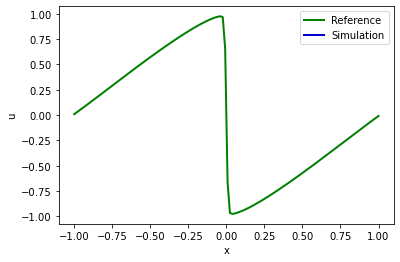

In [54]:
import pylab as plt

fig = plt.figure().gca()
pltx = np.linspace(-1,1,N)

fig.plot(pltx, SOLUTION_T16.values.numpy('x'), lw = 2, color = 'green', label = 'Reference')
fig.plot(pltx, velocities[16].values.numpy('x'), lw = 2, color = 'mediumblue', label = 'Simulation')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

In [3]:
# using tensorflow
from phi.tf.flow import CenteredGrid, extrapolation, Box, math
import numpy as np

N = 128
DX = 2 / N
STEPS = 32
DT = 1./ STEPS
NU = 0.2 / np.pi

velocity = CenteredGrid(0, extrapolation.PERIODIC, x = N, bounds = Box[-1:1])

REFERENCE_DATA = math.tensor(
    [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312]
    , math.spatial('x')
)

SOLUTION_T16 = CenteredGrid(REFERENCE_DATA, extrapolation.PERIODIC, x=N, bounds=Box[-1:1])

print(type(velocity.values.native()))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
# iterative algorithm : tensorflow also can not be converged
from phi.tf.flow import CenteredGrid, extrapolation, Box, math, math, diffuse, advect,field
iter_steps = 32
LR = 5
grads = []

velocity = CenteredGrid(0, extrapolation.PERIODIC, x = N, bounds = Box[-1:1])

for optim_step in range(iter_steps):
    velocities = [velocity]

    with math.record_gradients(velocity.values):
        for time_step in range(STEPS):
            v1 = diffuse.explicit(1.0*velocities[-1], NU, DT)
            v2 = advect.semi_lagrangian(v1,v1,DT)
            # print("time_step : {} and v1 : {} and v2 : {}".format(time_step, v1.values, v2.values))
            velocities.append(v2)
    
        loss = field.l2_loss(velocities[16] - SOLUTION_T16, ) * 2.0 / N
        print("Optimization step : {} and loss : {:.3f}".format(optim_step, loss))
        grad = math.gradients(loss, velocity.values)
        grads.append(grad)

    velocity = velocity - LR * grads[-1]

In [ ]:
import pylab as plt

fig = plt.figure().gca()
pltx = np.linspace(-1,1,N)

fig.plot(pltx, SOLUTION_T16.values.numpy('x'), lw = 2, color = 'green', label = 'Reference')
fig.plot(pltx, velocities[16].values.numpy('x'), lw = 2, color = 'mediumblue', label = 'Simulation')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()